In [1]:
import numpy as np
from keras import Model
from keras.layers import Dense, Input
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.
/home/ninja/anaconda3/envs/env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ninja/anaconda3/envs/env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ninja/anaconda3/envs/env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ninja/anaconda3/envs/env/l

ModuleNotFoundError: No module named 'sklearn'

In [3]:
TRAIN_DATA_PATH = 'data.npz'
INPUT_SHAPE = (5, )
OUTPUT_UNITS = 500

In [3]:
with np.load(TRAIN_DATA_PATH) as data:
    X = data['X']
    Y = data['Y']

In [4]:
print(X.shape, Y.shape)

(100000, 5) (100000, 500)


In [5]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1)

In [6]:
# clear memory size ~400MB
del X
del Y

In [8]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(90000, 5) (90000, 500) (10000, 5) (10000, 500)


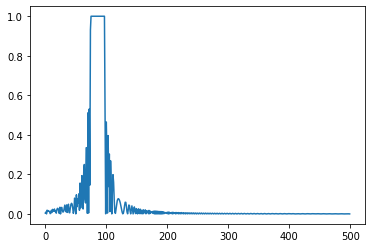

In [9]:
plt.plot(y_train[9796])

In [10]:
def build_model():
    inputs = Input(shape=INPUT_SHAPE, name='input_layer')
    
    l1 = Dense(50, activation='relu', name='hidden_layer1')(inputs)
    l2 = Dense(100, activation='relu', name='hidden_layer2')(l1)
    l3 = Dense(100, activation='relu', name='hidden_layer3')(l2)
    
    outputs = Dense(OUTPUT_UNITS, name='output_layer')(l3)
    
    model = Model(inputs=inputs, outputs=outputs, name='forward_model')
    model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    
    return model

In [11]:
model = build_model()

In [12]:
model.summary()

Model: "forward_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 5)                 0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 50)                300       
_________________________________________________________________
hidden_layer2 (Dense)        (None, 100)               5100      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 100)               10100     
_________________________________________________________________
output_layer (Dense)         (None, 500)               50500     
Total params: 66,000
Trainable params: 66,000
Non-trainable params: 0
_________________________________________________________________


In [14]:
model.fit(x_train, y_train, batch_size=32, epochs=5, validation_split=0.2)

Train on 72000 samples, validate on 18000 samples
Epoch 1/5
72000/72000 [==============================] - 12s 167us/step - loss: 0.0104 - accuracy: 0.0489 - val_loss: 0.0091 - val_accuracy: 0.0532
Epoch 2/5
72000/72000 [==============================] - 13s 185us/step - loss: 0.0084 - accuracy: 0.0601 - val_loss: 0.0077 - val_accuracy: 0.0629
Epoch 3/5
72000/72000 [==============================] - 13s 180us/step - loss: 0.0073 - accuracy: 0.0660 - val_loss: 0.0068 - val_accuracy: 0.0715
Epoch 4/5
72000/72000 [==============================] - 13s 182us/step - loss: 0.0066 - accuracy: 0.0699 - val_loss: 0.0065 - val_accuracy: 0.0593
Epoch 5/5
72000/72000 [==============================] - 12s 166us/step - loss: 0.0062 - accuracy: 0.0724 - val_loss: 0.0060 - val_accuracy: 0.0799


In [15]:
test_scores = model.evaluate(x_test, y_test, verbose=2)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])

Test loss: 0.006038507157564163
Test accuracy: 0.07779999822378159
